# Introduction

Analyse exploratoire des données importées via l'outil stackexchange explorer.

##### Contexte

Création d'un système de suggestion de tags pour le site stackoverflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

##### Récupération des données

Pour l'analyse exploratoire, j'ai récupéré l'ensemble des posts créés sur le site stackoverflow depuis sa création.
Je me suis focalisé uniquement sur les posts d'utilisateurs expérimentés (Réputation >= 10000, nombre de vues >= 5000).
Comme stackexchange explorer ne permet de collecter que maximum 50000 records à la fois, j'ai utilisé le champ Id de la table Posts pour découper mes requêtes.

##### Exemple de requête:

SELECT Title, Body, Tags, Score, ViewCount, OwnerUserId, Reputation, Views 

FROM Posts p, Users u 

WHERE p.OwnerUserId = u.Id 

AND p.Id <= 1000000 

AND PostTypeId = 1

AND Reputation >= 10000

AND Views >= 5000

AND Score IS NOT NULL

AND ViewCount IS NOT NULL

AND AnswerCount IS NOT NULL

AND CommentCount IS NOT NULL

AND FavoriteCount IS NOT NULL

AND Tags IS NOT NULL

In [1]:
# misc
import os
import re
import time
import warnings
import numpy as np
import pandas as pd

# preprocessing
import nltk
import spacy
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# lda
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# wordcloud
from wordcloud import WordCloud

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\james\anaconda3\envs\p5\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Allow to display all dataframes columns
pd.set_option("display.max_columns", None)

# Requested for nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inactivate warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Chargement des données

In [3]:
# New dataframe instanciation
data = pd.DataFrame()

# Process files
for idx, file in enumerate(os.listdir('./data')):
    print(idx, '-', file)
    path = './data/' + file
    df = pd.read_csv(path)
        
    data = pd.concat([data, df],
                      axis=0)

# Sort by Reputation
data.sort_values('Reputation', ascending=False, inplace=True)

# Reset index
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

0 - QueryResults_1.csv
1 - QueryResults_20.csv
2 - QueryResults_40.csv
3 - QueryResults_5.csv
4 - QueryResults_70.csv


# Analyse de forme

## Variables

In [4]:
data.columns

Index(['Title', 'Body', 'Tags', 'Score', 'ViewCount', 'OwnerUserId',
       'Reputation', 'Views'],
      dtype='object')

##### 4 groupes de variables:

- Titre et corps des posts
- Tags
- Score et nombre de vues des posts
- Id, score de réputation et nombre de vues de l'utilisateur

## Variable target

In [5]:
data['Tags'][0]

'<dnx><dnu>'

La variable Tags est une chaîne de caractères.

## Lignes et colonnes

In [6]:
print("Premières valeurs du dataset")
display(data.head())
print('\n' + '-' *50 +'\n')
print(f"Nombre d'observations: {data.shape[0]}, nombre de variables: {data.shape[1]}")

Premières valeurs du dataset


,Title,Body,Tags,Score,ViewCount,OwnerUserId,Reputation,Views
0,What is the expected behaviour of parent-relat...,"<p>(Now raised as <a href=""https://github.com/...",<dnx><dnu>,29,1392,22656,1313262,2122677
1,How can I diagnose missing dependencies (or ot...,<p>I'm trying to run a modified version of the...,<c#><asp.net-core><dnx>,135,50344,22656,1313262,2122677
2,How can I find out what's causing differences ...,"<p>In Noda Time, we generate our documentation...",<documentation><sandcastle><finalize><shfb>,48,2095,22656,1313262,2122677
3,Project management to go with GitHub,<p>(EDIT: This question is now outdated for my...,<git><open-source><project-management><github>...,96,22605,22656,1313262,2122677
4,Why does adding a dependency in my Web API (AS...,<p>I'm using Visual Studio 2015 CTP 6 on Windo...,<c#><asp.net-web-api><asp.net-core><visual-stu...,31,2218,22656,1313262,2122677



--------------------------------------------------

Nombre d'observations: 107376, nombre de variables: 8


## Types de variables

In [7]:
data.dtypes.value_counts()

int64     5
object    3
dtype: int64

Variables qualitatives : 4 (réintégration OwnerUserId), quantitatives : 4

## Valeurs manquantes

In [8]:
data.isnull().any()

Title          False
Body           False
Tags           False
Score          False
ViewCount      False
OwnerUserId    False
Reputation     False
Views          False
dtype: bool

Pas de valeurs manquantes

# Analyse de fond

## Visualisation de la target

In [9]:
# Split tags in a list
def split_tags(df):
    record = df['Tags'].replace('<', '').split('>')
    record = record[:-1]
    return record


data['Tags_list'] = data.apply(split_tags, axis=1)

In [10]:
# Count the tags in the tags list
def tags_number(df):
    return len(df['Tags_list'])


data['tags_number'] = data.apply(tags_number, axis=1)

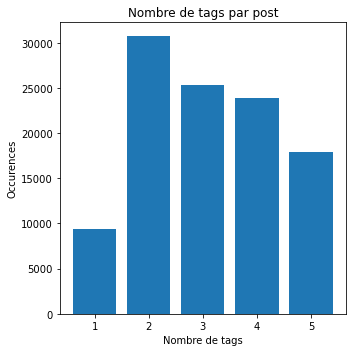

In [11]:
fig = plt.figure(figsize=(5, 5))
plt.bar(data['tags_number'].unique(), data['tags_number'].value_counts())
plt.title('Nombre de tags par post')
plt.xlabel('Nombre de tags')
plt.ylabel('Occurences')
plt.tight_layout()
plt.gcf().savefig('init_nomber_tags_post', dpi=100)
plt.show()

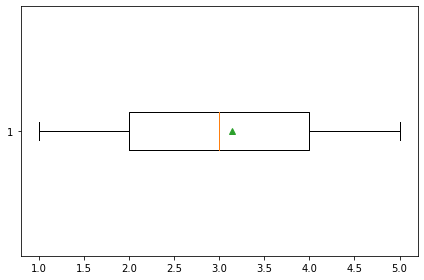

In [12]:
plt.boxplot(data['tags_number'], vert=False, showmeans=True, showfliers=False)
plt.tight_layout()
plt.gcf().savefig('boxplot_tags_number', dpi=100)
plt.show()

Le nombre de tags par post a une distribution empirique de 1 à 5 avec une médiane à 3 tags.

## Titre et corps des posts

In [13]:
def getFreq(df, column, number):
    # List the most frequent words in column
    wordsFrequences = {}
    final_words = {}

    for index, row in df.iterrows():
        try:
            title = row[column].split(' ')
        except:
            title = row[column]
            
        for word in title:
            if word in wordsFrequences.keys():
                wordsFrequences[word] += 1
            else:
                wordsFrequences[word] = 1

    print('Variable:', column)
    print('Nombre de mots uniques:', len(wordsFrequences))

    # Sort by number of occurence
    sorted_keys = sorted(wordsFrequences, key=wordsFrequences.get, reverse=True)  

    # Filter to get the top words frequency defined by parameter number
    for w in sorted_keys:
        final_words[w] = wordsFrequences[w]
        if len(final_words) == number:
            break

    # Display graph
    fig = plt.figure(figsize=(12, 5))
    plt.bar(final_words.keys(), final_words.values())
    plt.title('Les ' + str(number) + ' mots les plus fréquents dans la colonne ' + column)
    plt.xlabel('Mots')
    plt.ylabel('Occurences')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.gcf().savefig('most_frequent_words_' + column, dpi=100)
    plt.show()
    
    # Sort by number of occurence
    sorted_keys = sorted(wordsFrequences, key=wordsFrequences.get, reverse=False) 
    
    # Filter to get the top words frequency defined by parameter number
    final_words.clear()
    
    for w in sorted_keys:
        if wordsFrequences[w] == 1:
            final_words[w] = wordsFrequences[w]

    print('Nombre de mots rencontrés une seule fois:', len(final_words))
    print('')
    # Filter to get the top words frequency defined by parameter number
    final_words.clear()
    
    for w in sorted_keys:
        final_words[w] = wordsFrequences[w]
        if len(final_words) == number:
            break

    print('Les ' + str(number) + ' premiers mots rencontrés une seule fois dans la colonne ' + column)
    print(final_words.keys())
    
    return final_words

Variable: Title
Nombre de mots uniques: 89708


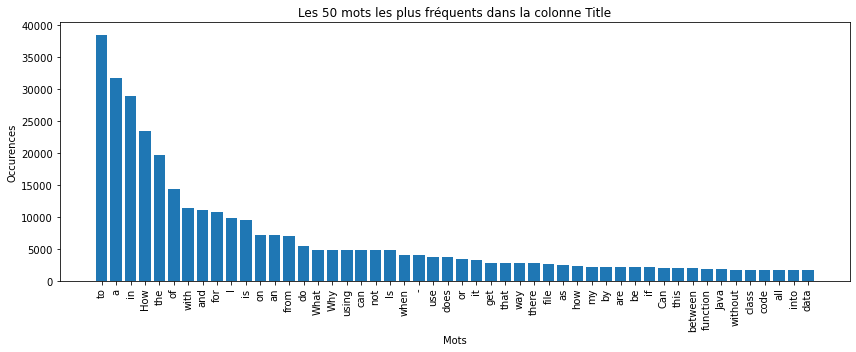

Nombre de mots rencontrés une seule fois: 60215

Les 50 premiers mots rencontrés une seule fois dans la colonne Title
dict_keys(['parent-relative', 'global.json?', 'dnx?', 'v5)', 'non-mutating', 'frameworkAssemblies', 'DbParameterCollection', 'SyntaxNode.ReplaceNode', 'SyntaxTree', 'school"', 'DNX/DNU?', 'cmdlets?', 'culture-sensitive', '"starts-with"', 'Document)', 'TextBox.TextChanged', 'CTP:', '"state"', 'EndAwait', 'DynamicMetaObject.BindInvokeMember?', 'PIA', '(non-ASP.NET', 'Task<T>.Convert<TResult>', '"sometimes', 'portable"', 'controversial', 'opinion?', "SHFB's", "IntelliSenseComponent's", '_Worksheet', 'Worksheet?', 'ccrewrite.exe', 'invariant?', 'misunderstood', 'metapackage?', '*latest*', 'difftool:', "diff'ed", 'wc', '*locally*?', 'detection:', 'AuthnProviderAlias', 'Apache2.4.x?', '1.1.2', '1.1.1?', 'more:', 'limits":', '"delayed', 'local"', 'java.net.URLConnection'])


In [14]:
freq1title = getFreq(data, 'Title', 50)

Stopwords, ponctuation et majuscules à nettoyer

Variable: Body
Nombre de mots uniques: 2019523


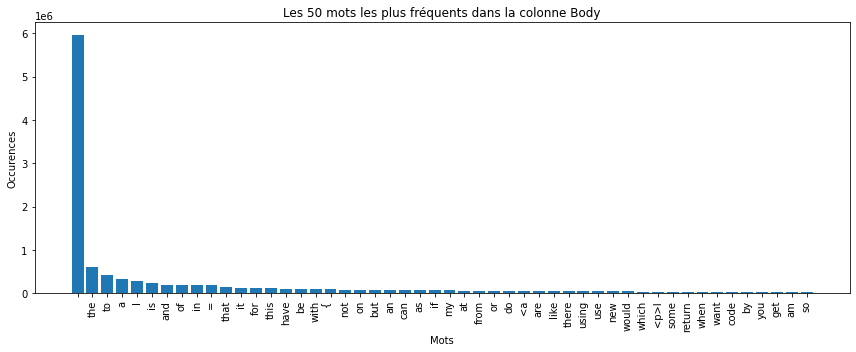

Nombre de mots rencontrés une seule fois: 1593366

Les 50 premiers mots rencontrés une seule fois dans la colonne Body
dict_keys(['<p>(Now', 'href="https://github.com/aspnet/dnx/issues/3206"', 'rel="noreferrer">DNX', '3206</a>...)</p>\n\n<p>DNX', '1.0.0-rc1,', 'x64.</p>\n\n<p>Imagine', 'solutions:</p>\n\n<ul>\n<li>Application1</li>\n<li>Application2</li>\n<li>Common</li>\n</ul>\n\n<p>Each', 'issue.</p>\n\n<p>Various', 'Application2', 'Common.', 'external),', '<code>global.json</code>', '"projects":', '"../Common/src"', '"sdk":', '"1.0.0-rc1-final"', 'directory</em>...', "'Common'", '0.0.0-*".)', 'Application1</code>', "restore</code>.</p>\n\n<p>I've", '"./Common/src",', '"Common/src",', '"../repo-name/Common/src"),', 'packages.</p>\n\n<p>So,', '<code>"../Common/src"</code>', '<code>global.json</code>?', 'resonable', 'DNX?</p>\n', 'href="https://github.com/aspnet/Home/tree/master/samples/HelloWeb"', 'rel="noreferrer">HelloWeb', ':)</p>\n\n<p>Environment:</p>\n\n<ul>\n<li>Linux', '(Ubunt

In [15]:
freq1body = getFreq(data, 'Body', 50)

- Présence de balises html
- Présence de code et scripts

## Score et nombre de vues des posts

In [16]:
data['Score'].describe()

count    107376.000000
mean         22.885626
std         169.874820
min        -146.000000
25%           2.000000
50%           5.000000
75%          13.000000
max       26203.000000
Name: Score, dtype: float64

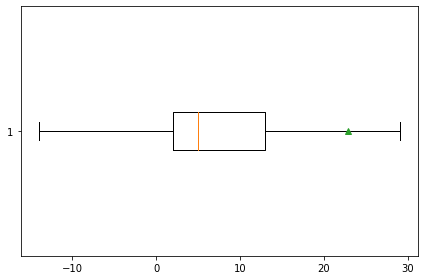

In [17]:
plt.boxplot(data['Score'], vert=False, showmeans=True, showfliers=False)
plt.tight_layout()
plt.gcf().savefig('boxplot_score', dpi=100)
plt.show()

In [18]:
data['ViewCount'].describe()

count    1.073760e+05
mean     1.834312e+04
std      1.009792e+05
min      1.100000e+01
25%      7.220000e+02
50%      2.522000e+03
75%      9.100000e+03
max      9.655466e+06
Name: ViewCount, dtype: float64

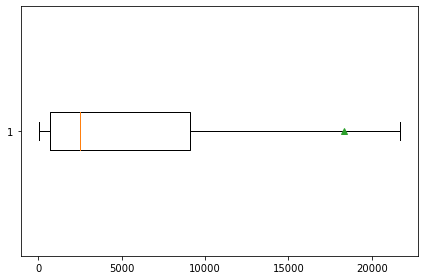

In [19]:
plt.boxplot(data['ViewCount'], vert=False, showmeans=True, showfliers=False)
plt.tight_layout()
plt.gcf().savefig('boxplot_viewCount', dpi=100)
plt.show()

## Id, score de réputation et nombre de vues de l'utilisateur

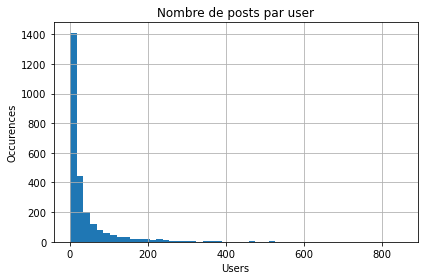

In [20]:
data['OwnerUserId'].value_counts().hist(bins=50)
plt.title('Nombre de posts par user')
plt.xlabel('Users')
plt.ylabel('Occurences')
plt.tight_layout()
plt.gcf().savefig('Nombre_posts_user', dpi=100)
plt.show()

In [21]:
data['Reputation'].describe()

count    1.073760e+05
mean     1.180850e+05
std      1.133272e+05
min      1.022100e+04
25%      4.855300e+04
50%      8.299900e+04
75%      1.456060e+05
max      1.313262e+06
Name: Reputation, dtype: float64

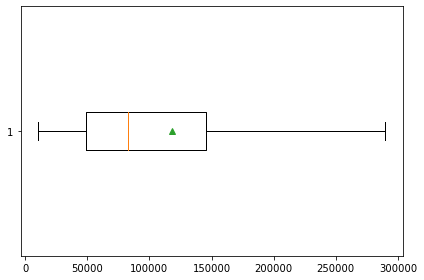

In [22]:
plt.boxplot(data['Reputation'], vert=False, showmeans=True, showfliers=False)
plt.tight_layout()
plt.gcf().savefig('boxplot_Reputation', dpi=100)
plt.show()

In [23]:
data['Views'].describe()

count    1.073760e+05
mean     1.531338e+04
std      5.002240e+04
min      5.002000e+03
25%      6.121000e+03
50%      8.566000e+03
75%      1.373200e+04
max      2.122677e+06
Name: Views, dtype: float64

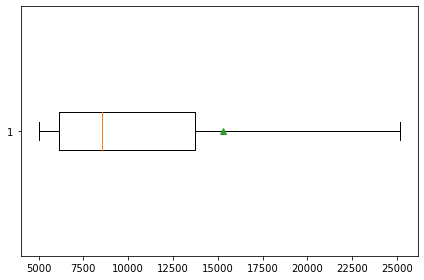

In [24]:
plt.boxplot(data['Views'], vert=False, showmeans=True, showfliers=False)
plt.tight_layout()
plt.gcf().savefig('boxplot_Views', dpi=100)
plt.show()

# Filtrage des données

Je filtre tout d'abord les valeurs atypiques en me focalisant sur les posts dont les variables Score, ViewCount, Reputation et Views sont comprises dans leur écart inter-quartile.

In [25]:
# Calculate interquantiles

# Reputation
diffReputation = data['Reputation'].quantile(.5) - data['Reputation'].quantile(.25)
limMinReputation = data['Reputation'].quantile(.25) - (1.5 * diffReputation)
limMaxReputation = data['Reputation'].quantile(.75) + (1.5 * diffReputation)

# Views
diffViews = data['Views'].quantile(.5) - data['Views'].quantile(.25)
limMinViews = data['Views'].quantile(.25) - (1.5 * diffViews)
limMaxViews = data['Views'].quantile(.75) + (1.5 * diffViews)

# Score
diffScore = data['Score'].quantile(.5) - data['Score'].quantile(.25)
limMinScore = data['Score'].quantile(.25) - (1.5 * diffScore)
limMaxScore = data['Score'].quantile(.75) + (1.5 * diffScore)

# ViewCount
diffViewCount = data['ViewCount'].quantile(.5) - data['ViewCount'].quantile(.25)
limMinViewCount = data['ViewCount'].quantile(.25) - (1.5 * diffViewCount)
limMaxViewCount = data['ViewCount'].quantile(.75) + (1.5 * diffViewCount)

In [26]:
filtered_data = data[(data['Reputation'] >= limMinReputation) &
                     (data['Reputation'] <= limMaxReputation) &
                     (data['Views'] >= limMinViews) &
                     (data['Views'] <= limMaxViews) &
                     (data['Score'] >= limMinScore) &
                     (data['Score'] <= limMaxScore) &
                     (data['ViewCount'] >= limMinViewCount) &
                     (data['ViewCount'] <= limMaxViewCount)
                    ]
filtered_data.sort_values('Reputation', ascending=False, inplace=True)
print(
    f"Nombre d'observations: {filtered_data.shape[0]}, nombre de variables: {filtered_data.shape[1]}")
print(
    f"Proportion d'observations sélectionnées: {round(filtered_data.shape[0] / data.shape[0]*100,3)}%")

Nombre d'observations: 61325, nombre de variables: 10
Proportion d'observations sélectionnées: 57.112%


Puis je filtre pour ne conserver que les posts ayant comme tags des tags parmi les 50 plus fréquents.

In [27]:
# List the most frequent tags
tagsFrequences = {}
final = {}

for index, row in filtered_data.iterrows():
    title = row['Tags_list']

    for word in title:
        if word in tagsFrequences.keys():
            tagsFrequences[word] += 1
        else:
            tagsFrequences[word] = 1

print('Nombre de tags uniques:', len(tagsFrequences))

# Sort by number of occurence
sorted_keys = sorted(tagsFrequences, key=tagsFrequences.get, reverse=True)  

# Filter to get the top 50 most frequent tags
for w in sorted_keys:
    final[w] = tagsFrequences[w]
    if len(final) == 50:
        break

Nombre de tags uniques: 15895


In [28]:
def most_frequent_tag_filter(df):
    boo_test = False

    taglist = df['Tags_list']
    for i in range(0, len(taglist)):
        if taglist[i] in final.keys():
            boo_test = True
        else:
            boo_test = False
            break

    return boo_test


Filter = filtered_data.apply(most_frequent_tag_filter, axis=1)
filtered_data = filtered_data[Filter]
print(
    f"Nombre d'observations: {filtered_data.shape[0]}, nombre de variables: {filtered_data.shape[1]}")
print(
    f"Proportion d'observations sélectionnées: {round(filtered_data.shape[0] / data.shape[0]*100,3)}%")

Nombre d'observations: 5794, nombre de variables: 10
Proportion d'observations sélectionnées: 5.396%


Point de sauvegarde

In [29]:
filtered_data.to_pickle('filtered_data.pkl')

# Cleaning des données

In [ ]:
filtered_data = pd.read_pickle('filtered_data.pkl')  

## Définition des fonctions

In [ ]:
# Tokenisation
# \w+ matches any word character (equal to [a-zA-Z0-9_])
tokenizer = nltk.RegexpTokenizer(r'\w+')

# Stopwords definition
all_stopwords = stopwords.words('english')
all_stopwords.extend(freq1title.keys())
all_stopwords.extend(freq1body.keys())

# Lemmatization
lemmatizer = WordNetLemmatizer()

# Delete numbers
r = re.compile(".*[a-zA-Z]")

# Delete verbs with Part of speech (POS)
pos = spacy.load("en_core_web_sm")

def preprocessing(text):
    # HTML cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove punctuation
    text = re.sub('[,;:.!?]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenisation
    text = tokenizer.tokenize(text)

    # Stopwords deletion
    text = [word for word in text
            if not word in all_stopwords]

    # Lemmatization
    result = []
    for word in text:
        result.append(lemmatizer.lemmatize(word))
    text = result

    # Delete numbers
    text = list(filter(r.match, text))
    
    # PRON, AUX, ADV, ADJ, PART, VERB, DET, NOUN, ADP
    # Remove AUX, VERB
    result = []
    doc = pos(' '.join(text))
    for token in doc:
        if token.pos_ != 'AUX' and token.pos_ != 'VERB':
            result.append(token.text)
    text = result

    return text

In [ ]:
def token_to_string(df):
    return ' '.join(df['list_tokens'])

# Columns deletion
def drop(df, col_list):
    df = df.drop(col_list, axis=1)
    return df

# -----------------------------------------------
# Feature engineering

# Number of characters per post
def post_char_count(df):
    return len(''.join(df['list_tokens']))

# Number of tokens per post
def post_token_count(df):
    return len(df['list_tokens'])

# Average number of characters per word
def post_avg_wordlength(df):
    return df['post_char_count'] / df['post_token_count']

## Preprocessing

### Merging Title et Body

In [ ]:
filtered_data['text'] = filtered_data['Title'] + ' ' + filtered_data['Body']

### Preprocess text

In [ ]:
filtered_data['list_tokens'] = filtered_data['text'].apply(lambda x: preprocessing(x))

In [ ]:
filtered_data['str_tokens'] = filtered_data.apply(token_to_string, axis=1)

In [ ]:
print(
    f"Nombre d'observations: {filtered_data.shape[0]}, nombre de variables: {filtered_data.shape[1]}")

### Features engineering

In [ ]:
# Number of characters per post
filtered_data['post_char_count'] = filtered_data.apply(post_char_count, axis=1)

# Number of tokens per post
filtered_data['post_token_count'] = filtered_data.apply(post_token_count, axis=1)

# Remove post without words
filtered_data = filtered_data[filtered_data['post_token_count'] != 0]

# Average number of characters per word
filtered_data['post_avg_wordlength'] = filtered_data.apply(post_avg_wordlength, axis=1)

Point de sauvegarde

In [ ]:
filtered_data.to_pickle('preprocessed_data.pkl')

### Cleaning

In [ ]:
preprocessed_data = pd.read_pickle('preprocessed_data.pkl')  

In [ ]:
preprocessed_data.columns

In [ ]:
# Delete useless columns
print('Delete useless columns...')
collist = ['Title', 'Body', 'Tags', 'Score', 'ViewCount', 'OwnerUserId',
           'Reputation', 'Views', 'tags_number']
print(collist)
preprocessed_data = drop(preprocessed_data, collist)
preprocessed_data = preprocessed_data.reset_index()
preprocessed_data = drop(preprocessed_data, ['index'])

### Remove duplicates

In [ ]:
print('Number of duplicates: ', preprocessed_data['str_tokens'].duplicated().sum())
preprocessed_data.drop_duplicates(subset='str_tokens', keep='last', inplace=True)

In [ ]:
print(
    f"Nombre d'observations: {preprocessed_data.shape[0]}, nombre de variables: {preprocessed_data.shape[1]}")

# Analyse exploratoire

## Univariée

### Nombre de caractères par post

In [ ]:
preprocessed_data['post_char_count'].hist(bins=50)
plt.xlabel('Nombre de caractères')
plt.ylabel('Occurences')
plt.title('Nombre de caractères par post')
plt.tight_layout()
plt.gcf().savefig('post_char_count', dpi=100)
plt.show()